In [2]:
import uproot4
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from matplotlib import cm
from matplotlib.colors import LogNorm, Normalize
import os
import numpy as np
import pandas as pd
import itertools

from event_display import  table_display, table_display_compare, get_bin_centers

In [3]:
pics_prefix = os.path.join("plots", "v1_")

In [4]:
from geant3_parser import build_true_answers_train_set
from geant3_parser import Geant3DataFile

def norm_func(e):
    return np.float64(np.log(e) / 11)

file_name = os.path.join('data', 'shower_geant3_new.dat')
data_file = Geant3DataFile(file_name, skip_lines=3)
input_data, answers, values = build_true_answers_train_set(data_file, 50000, norm_func=norm_func, rnd_shift=((-2,2), (-2,2)))
print(np.shape(answers))
print(np.shape(input_data))

# Remove x,y

# Reshape to events x 11 x 11 x 1 form
input_data = np.reshape(input_data, (len(input_data), 11, 11, 1))  # -1 => autodetermine
answers = np.reshape(answers, (len(answers), 11, 11, 1))  # -1 => autodetermine
print(np.shape(answers))
print(np.shape(input_data))


# Pad with 1 row and column of zeroes, so it divides by 2, events x 12 x 12 x 1 now
#input_data = np.pad(input_data, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)
#answers = np.pad(answers, ((0,0), (0,1), (0,1), (0,0)), mode='constant', constant_values=0)

# printout shape
print(f"Inputs shape new = {np.shape(input_data)}")

Time open 0.32794690132141113
Time split 0.37566447257995605
(50000, 11, 11)
(50000, 11, 11)
(50000, 11, 11, 1)
(50000, 11, 11, 1)
Inputs shape new = (50000, 11, 11, 1)


In [5]:
# Load NN model
from keras.models import load_model
model = load_model(os.path.join('trained_models', 'g3_conv.hd5'))

# Run ML on data
ml_events = model.predict(input_data)
# reshape events
ml_events = np.reshape(ml_events, (len(ml_events), 11, 11, 1))


[[[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [245.51051]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]]

 [[  1.     ]
  [  1.     ]
  [  1.     ]
  [  1.     ]
  [  1. 

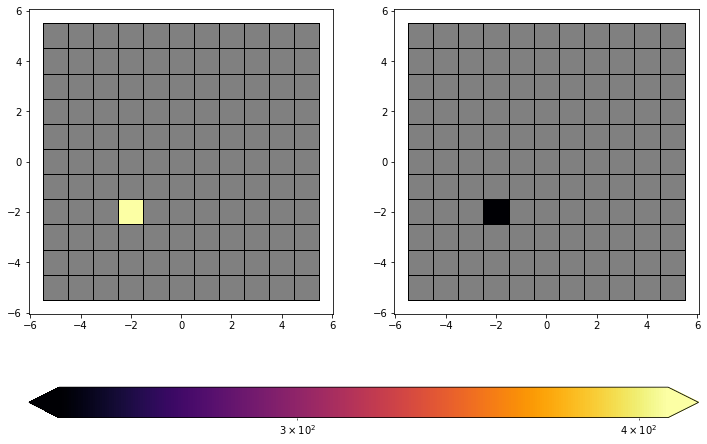

In [15]:
# exponentiate data
true_event = np.exp(answers[5]*11)
ml_event = np.exp(ml_events[5]*11)

print(ml_event)
print("true event")
print(true_event)

# clear low data for display
ml_event[ml_event<2] = 0
true_event[true_event<1.5] = 0

table_display_compare(true_event, ml_event, cal_size=11)
print(f"max true {np.max(true_event)} max eval {np.max(ml_event)}")
print(f"sum true {np.sum(true_event)} sum eval {np.sum(ml_event)}")

In [7]:
def data_to_energies(data):
    # We took log(hit) to make hits linear. /11 as a scale. Now reverting it    
    denorm_data = np.exp(data*11)

    # Get rid of array form of cells
    # For ML you have arrays like 
    # [num_pictures][x_pixels][y_pixels][colors]  where colors=3 for RGB,  colors=1 for BW
    # We use colors=1 (we just have an energy deposit in a cell) and we have num_pictures=num_events, [xy]_pixels=[xy]_cells
    # No we want to remove this useless [1]
    # (len(data), 12, 12, 1) => (len(data), 12, 12)
    reshaped = np.reshape(denorm_data, (len(data), 11, 11))

    # Sum along (x_pixels, y_pixels) axis => basicly summ everything in one event
    sums = np.sum(reshaped, axis=(1,2))
    return sums

sr_e = data_to_energies(input_data)             # SR = simple reco = energy from original data, summed together
ml_e = data_to_energies(ml_events)              # Energy from ML (sum everything)
true_e = 1000*np.reshape(values[:,0], len(input_data))    # True energy, 1000 to convert from GeV to

# create pandas table... for fun
pd = pd.DataFrame({"sr_e": sr_e, "ml_e": ml_e, "true_e":true_e})

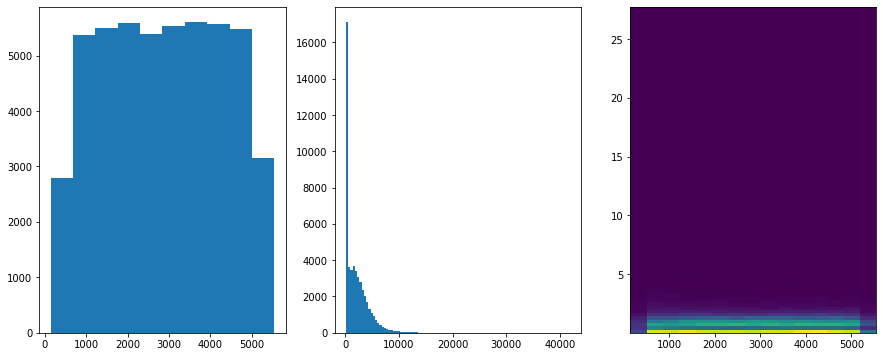

In [8]:
# using tuple unpacking for multiple Axes
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

ax1.hist(sr_e, bins=10)
ax2.hist(ml_e, bins=100)
ax3.hist2d(sr_e, ml_e/sr_e, bins=(15, 100))
plt.savefig(pics_prefix + "e_2dhist.png")
plt.show()


In [9]:
# Build numpy 2d histogram
err_bins = np.arange(0.4, 1.4, 0.05)
e_bins = np.arange(0, 6000, 500)
err_bin_centers = get_bin_centers(err_bins)
e_bin_centers = get_bin_centers(e_bins)
de = ml_e/sr_e
dee_hist, de_bin_edges, e_bin_edges = np.histogram2d(sr_e, de, bins=[e_bins, err_bins])
e_bins_num, dee_bins_num = dee_hist.shape
e_bins_num, dee_bins_num, len(err_bin_centers)

(11, 19, 19)

Total subplots: 11 plot rows=3 columns=4


[]

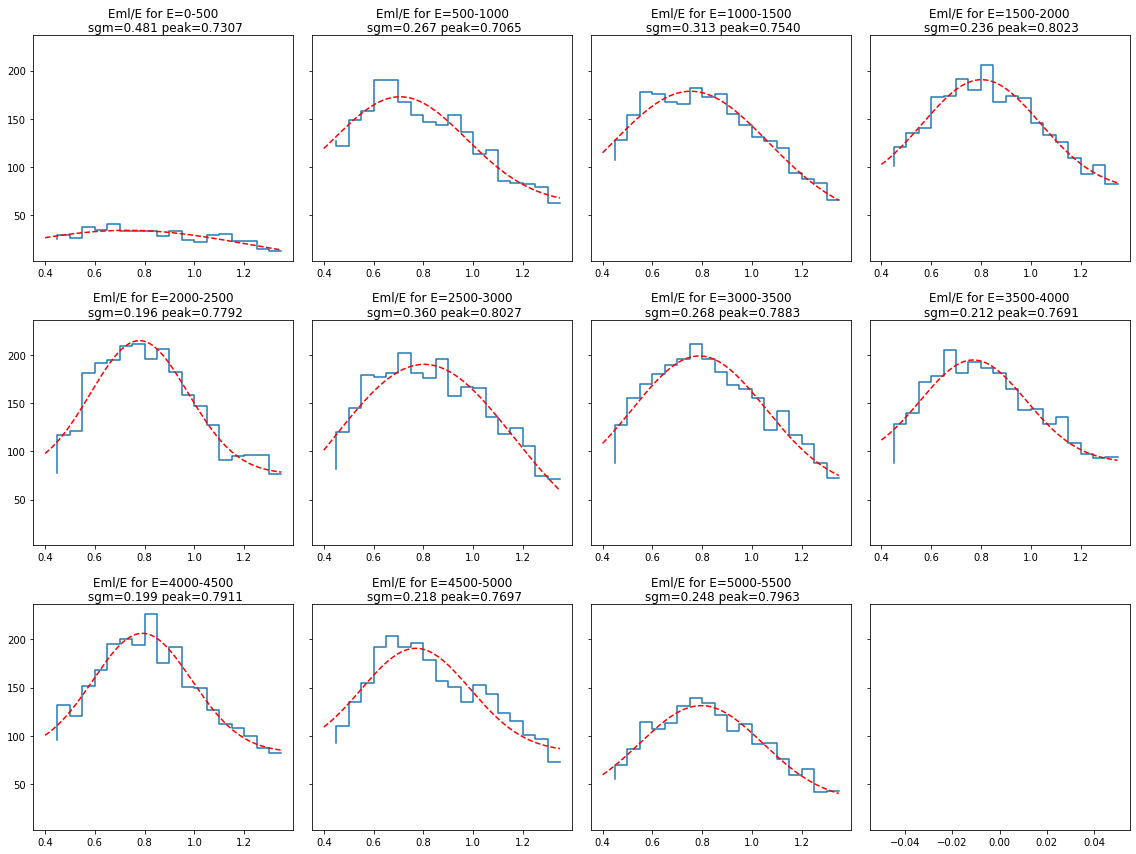

In [10]:
plot_columns = 4
plot_rows = int(e_bins_num / plot_columns) + 1
(int(e_bins_num/plot_columns) + 1)*plot_columns
print(f"Total subplots: {e_bins_num} plot rows={plot_rows} columns={plot_columns}")
fig, axes = plt.subplots(plot_rows, plot_columns, figsize=(plot_columns*4, plot_rows*4), sharey=True)

from statistics import NormalDist
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Fit fragment is taken from here
# https://gist.github.com/cpascual/a03d0d49ddd2c87d7e84b9f4ad2df466
def gauss(x, H, A, x0, sigma):
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

def gauss_fit(x, y):
    mean = sum(x * y) / sum(y)
    sigma = np.sqrt(sum(y * (x - mean) ** 2) / sum(y))
    popt, pcov = curve_fit(gauss, x, y, p0=[min(y), max(y), mean, sigma])
    return popt

# axes is a 2d array consisting of rows and colums [[...], [...], ...]
# flatten it as we need to feel it one by one
axes = list(itertools.chain.from_iterable(axes))
sigmas = []
dee_peaks = []
for i in range(e_bins_num):
    hist1d = dee_hist[i]
    ax = axes[i]
    # (!) using ax.step() for histograms
    # But commented ax.plot() to check ax.step() centers correctness
    # ax.plot(err_bin_centers, hist1d, "-o")    
    ax.step(err_bins[1:], hist1d)

    # Fit using Gaussian function
    H, A, x0, sigma = gauss_fit(err_bin_centers, hist1d)
    std = np.std(hist1d)    

    # Plot gauss
    smooth_gauss_x = np.arange(err_bins[0], err_bins[-1], (err_bins[-1]-err_bins[0])/1000)
    smooth_gauss_y = gauss(smooth_gauss_x, H, A, x0, sigma)
    ax.plot(smooth_gauss_x, smooth_gauss_y, '--r', label='fit')

    # titles
    ax.set_title(f"Eml/E for E={e_bins[i]}-{e_bins[i+1]}\n sgm={sigma:.3f} peak={x0:.4f}", wrap=True)  

    # Add our error
    sigmas.append(sigma)
    dee_peaks.append(x0)
    

plt.tight_layout()
plt.savefig(pics_prefix + "ml_div_true_fit")
plt.plot()

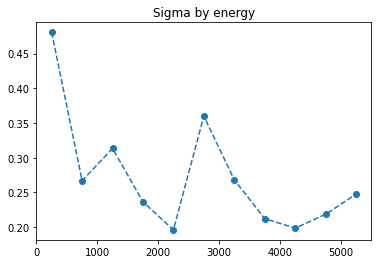

In [11]:
plt.plot(e_bin_centers, sigmas, "--o")
plt.title("Sigma by energy")
plt.savefig(pics_prefix + "errors")

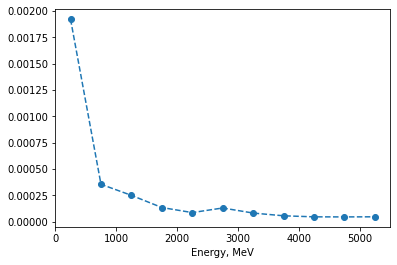

In [12]:
sigma_div_e = sigmas/e_bin_centers

plt.plot(e_bin_centers, sigma_div_e, "--o")
plt.xlabel("Energy, MeV")
plt.savefig(pics_prefix + "errors_div_energy")

a=-0.024985170989458474 b=0.8088277847027993 c=0.0002583305685721617


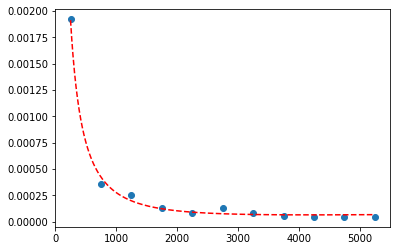

In [13]:
def calo_error(x, a, b, c):
    return a/np.sqrt(x) + b/x + c

popt, pcov = curve_fit(calo_error, e_bin_centers, sigma_div_e, p0=[1, 1, 0])
a, b, c = popt
print(f"a={a} b={b} c={c}")

# Plot gauss
smooth_cal_x = np.arange(e_bin_centers[0], e_bin_centers[-1], (e_bin_centers[-1]-e_bin_centers[0])/1000)
smooth_cal_y = calo_error(smooth_cal_x, a, b, c)

fig, ax = plt.subplots()
ax.plot(e_bin_centers, sigma_div_e, "o")
ax.plot(smooth_cal_x, smooth_cal_y, '--r', label='fit')


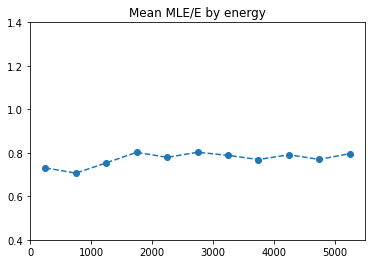

In [14]:
plt.plot(e_bin_centers, dee_peaks , "--o")
plt.title("Mean MLE/E by energy")
plt.ylim(0.4,1.4)
plt.savefig(pics_prefix + "ml_div_true_peaks")